In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from open_spiel.python.examples.ubc_notebook_imports import *
from open_spiel.python.algorithms.exploitability import _state_values

Loading BokehJS ...

In [8]:
# load runs from experiments
experiments = []
# experiments += ['jun24_cfr_gamut_6'] 
# experiments += ['jun24_cfr_gamut_7']
# experiments += ['jun26_port']
experiments += ['jul19']
runs = []
for experiment in experiments:
    runs += Experiment.objects.get(name=experiment).equilibriumsolverrun_set.all()
print(f"Found {len(runs)} runs")

Found 300 runs


In [72]:
runs_by_game = defaultdict(list)
for run in tqdm(runs):
    runs_by_game[run.game.name].append(run)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 487331.99it/s]


In [75]:
runs_by_game.keys()

dict_keys(['jun26/jun26_0_high_speed.json', 'jun26/jun26_4_medium_speed.json', 'jun26/jun26_1_grace_period.json', 'jun26/jun26_2_high_speed.json', 'jun26/jun26_0_medium_speed.json', 'jun26/jun26_0_base.json', 'jun26/jun26_4_high_speed.json', 'jun26/jun26_1_no_activity.json', 'jun26/jun26_0_no_activity.json', 'jun26/jun26_3_high_speed.json', 'jun26/jun26_3_base.json', 'jun26/jun26_2_no_activity.json', 'jun26/jun26_1_base.json', 'jun26/jun26_3_no_activity.json', 'jun26/jun26_4_base.json', 'jun26/jun26_3_grace_period.json', 'jun26/jun26_2_medium_speed.json', 'jun26/jun26_1_high_speed.json', 'jun26/jun26_0_grace_period.json', 'jun26/jun26_1_medium_speed.json', 'jun26/jun26_4_no_activity.json', 'jun26/jun26_2_base.json', 'jun26/jun26_4_grace_period.json', 'jun26/jun26_2_grace_period.json', 'jun26/jun26_3_medium_speed.json'])

In [74]:
# TODO: 1) Solve mem issue
#       2) Need to check on Nash/HeuristicConv of runs and filter them, so that uncoveged runs don't get to count against your robustness

def compute_empirical_game(run_list):
    num_players = run_list[0].game.num_players
    empirical_payoffs = np.zeros([len(run_list)] * num_players + [num_players]) 
    
    agents_list = []
    for run in tqdm(run_list):
        game, final_checkpoint, _ = get_results(run, load_policy=False)
        env_and_policy = ppo_db_checkpoint_loader(final_checkpoint)
        for player in range(game.num_players()):
            env_and_policy.agents[player] = ModalAgentDecorator(env_and_policy.agents[player])
        agents_list.append(env_and_policy.agents)
        
    mutable_env_and_policy = ppo_db_checkpoint_loader(final_checkpoint)
    
    for run_combo in tqdm(itertools.product(range(len(run_list)), repeat=num_players), total=len(run_list)**num_players):
        for player, player_run in enumerate(run_combo):
            mutable_env_and_policy.agents[player] = agents_list[player_run][player]
        policy = mutable_env_and_policy.make_policy()
        payoffs = _state_values(game.new_initial_state(), num_players, policy)
        empirical_payoffs[run_combo] = payoffs
        
    return empirical_payoffs

empirical_payoffs = compute_empirical_game(runs_by_game['jun26/jun26_2_no_activity.json'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:03<00:00, 44.53it/s]


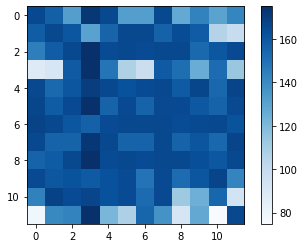

In [76]:
plt.imshow(empirical_payoffs[:, :, 0], cmap='Blues')
plt.colorbar()

In [82]:
def compute_robustness_df(run_by_game_dict):
    records = []
    for game_name in run_by_game_dict:
        print(game_name)
        game_runs = run_by_game_dict[game_name]
        empirical_payoffs = compute_empirical_game(game_runs)
        
        for run_num, run in enumerate(game_runs):
            record = {
                'game_name': run.game.name, 
                'run_name': run.name,
            }
            for player in range(2):
                player_payoffs = empirical_payoffs[:, :, player]
                if player == 1:
                    player_payoffs = player_payoffs.T

                actual_payoff = player_payoffs[run_num, run_num]
                uniform_payoff = player_payoffs[run_num, :].mean()

                record.update({
                    f'actual_payoff_{player}': actual_payoff,
                    f'uniform_payoff_{player}': uniform_payoff,
                    f'lost_vs_uniform_{player}': actual_payoff - uniform_payoff,
                    f'frac_lost_vs_uniform_{player}': (actual_payoff - uniform_payoff) / actual_payoff,
                })
            records.append(record)
            
    df = pd.DataFrame.from_records(records)
    df['worst_lost_vs_uniform'] = df[['lost_vs_uniform_0', 'lost_vs_uniform_1']].max(axis='columns')
    df['worst_frac_lost_vs_uniform'] = df[['frac_lost_vs_uniform_0', 'frac_lost_vs_uniform_1']].max(axis='columns')
    return df

In [ ]:
compute_robustness_df(runs_by_game)

jun26/jun26_0_high_speed.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:02<00:00, 70.77it/s]


jun26/jun26_4_medium_speed.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:02<00:00, 69.69it/s]


jun26/jun26_1_grace_period.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:02<00:00, 58.45it/s]


jun26/jun26_2_high_speed.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 90.54it/s]


jun26/jun26_0_medium_speed.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:02<00:00, 55.99it/s]


jun26/jun26_0_base.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:03<00:00, 44.34it/s]


jun26/jun26_4_high_speed.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 83.95it/s]


jun26/jun26_1_no_activity.json


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 8/12 [01:57<00:57, 14.40s/it]

In [ ]:
df.to_csv('robustness_jul19.csv', index=False)

In [77]:
records = []
for player in range(2):
    print(f'Player {player}')
    for run_num in range(empirical_payoffs.shape[player]):
        player_payoffs = empirical_payoffs[:, :, player]
        if player == 1:
            player_payoffs = player_payoffs.T
        
        actual_payoff = player_payoffs[run_num, run_num]
        uniform_payoff = player_payoffs[run_num, :].mean()
        alpha = (actual_payoff * 0.10) / (actual_payoff - uniform_payoff)

        print(f'{run_num:2d}: {alpha:.3f}')
        
        records.append({
            'player': player,
            'run': run_num,
            'robustness': alpha,
            'actual_payoff': actual_payoff,
            'uniform_payoff': uniform_payoff,
            'frac_vs_uniform': uniform_payoff / actual_payoff,
        })
        
df = pd.DataFrame.from_records(records)
df.sort_values('frac_vs_uniform')

Player 0
 0: 0.894
 1: 0.977
 2: 5.200
 3: 0.392
 4: 5.969
 5: 6.156
 6: 10.056
 7: 3.426
 8: 11.629
 9: 11.587
10: 2.399
11: 0.425
Player 1
 0: 0.685
 1: 0.668
 2: 0.696
 3: 0.607
 4: 0.671
 5: 1.297
 6: 0.820
 7: 0.963
 8: 1.042
 9: 0.556
10: 0.639
11: 0.350


,player,run,robustness,actual_payoff,uniform_payoff,frac_vs_uniform
23,1,11,0.349840,32.520000,23.224318,0.714155
3,0,3,0.392485,174.877095,130.320726,0.745213
11,0,11,0.425397,165.147225,126.325352,0.764926
21,1,9,0.556151,30.371555,24.910526,0.820193
15,1,3,0.607288,29.136886,24.339018,0.835334
22,1,10,0.638964,34.290636,28.924034,0.843497
13,1,1,0.668173,32.229610,27.406064,0.850338
16,1,4,0.670553,32.229610,27.423186,0.850869
12,1,0,0.685008,32.229610,27.524612,0.854016
14,1,2,0.696239,32.229610,27.600510,0.856371


,player,run,robustness,actual_payoff,uniform_payoff,frac_vs_uniform
11,0,11,0.190456,13.372395,6.351145,0.474944
1,0,1,0.224003,13.308566,7.367316,0.553577
0,0,0,0.306520,13.245505,8.924255,0.673757
7,0,7,0.457089,13.868224,10.834192,0.781224
3,0,3,0.521995,13.804395,11.159851,0.808427
8,0,8,0.581598,13.804395,11.430865,0.828060
4,0,4,0.672734,13.280488,11.306383,0.851353
16,1,4,0.752338,157.260000,136.357159,0.867081
15,1,3,0.753145,166.380000,144.288637,0.867223
20,1,8,0.802957,166.380000,145.659089,0.875460


In [ ]:
# empirical = True
# USE_MODAL = True

records = []
for run in tqdm(runs):
    try:
    
        try:
            game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=True, load_policy=False)
        except Exception as e:
            print(f"Skipping run {run.name} because of error {e}")
            continue

#         if USE_MODAL:
#             evaluation = final_checkpoint.get_modal_eval()
#             # if make_combo_specific(evaluation):
#             #     print(run.name)
#         else:
#             evaluation = final_checkpoint.get_old_eval()
            
            
        # total_entropy = analyze_samples(final_checkpoint.get_old_eval().samples, game)['total_entropy'] # Use old eval since modal is stupid for this and it's a convergence test

        # if empirical: 
        #     history_dists = empirical_history_distribution(final_checkpoint.get_old_eval()) # Always use the old eval here
        #     history_entropies = [scipy.stats.entropy(list(history_dists.loc[type_combo].values)) for type_combo in np.unique(history_dists.index.get_level_values(0))]
        # else:
        #     history_dists = compute_per_type_combo(history_distribution, policy, game, min_prob=0.01, history_type='processed')
        #     history_entropies = [scipy.stats.entropy(list(history_dists[type_combo].values())) for type_combo in history_dists]

        # try:
        #     # TODO: Broken until you remove "Tremble" agents
        #     _, _, approx_nash_conv = find_best_checkpoint(run)
        # except:
        #     # TODO: Fix bug where this actually happens because your BRs failed to do better and you have an Empirical Nash Conv of 0, very different from NaN
        #     # ev_df = parse_run(run, None)
        #     # display(ev_df)
        #     approx_nash_conv = np.nan

        record = {
            # clock auction params
            'game_name': run.game.name, 
            'potential': run.config.get('potential_function', 'None'),
            'seed': run.config.get('seed'), 
            'run_name': run.name,
            'experiment': run.experiment.name,
            'config': run.get_config_name(),
            't': final_checkpoint.t,

            # CMA knobs
            'information_policy': InformationPolicy(game.auction_params.information_policy).name,
            'activity_policy': ActivityPolicy(game.auction_params.activity_policy).name,
            'undersell_policy': UndersellPolicy(game.auction_params.undersell_policy).name,
            'tiebreaking_policy': TiebreakingPolicy(game.auction_params.tiebreaking_policy).name,
            'grace_rounds': game.auction_params.grace_rounds,
            'risk_aversion': 'risk' in run.game.name, # TODO: actually read this from players
            'spite': 'spite' in run.game.name, # TODO: actually read this from players
            'clock_speed': game.auction_params.increment,
            'base_game_name': '_'.join(run.game.name.split('/')[1].split('_')[:2]), # Stupid naming convention that will surely bite us later

            # solver information
            'alg': get_algorithm_from_run(run),
            'walltime': run.walltime(),

            # metrics from eval
            # 'total_entropy': total_entropy,

            # stats about history distribution
            # 'avg_distinct_histories': np.mean([len(d) for d in history_dists.values()]),
            # 'avg_history_entropy': np.mean(history_entropies),
        } 
        
        evaluation = final_checkpoint.get_modal_eval()
        # evaluation = final_checkpoint.get_old_eval()
        
        record['nash_conv'] = evaluation.nash_conv
        record['rewards'] = evaluation.mean_rewards
        record['nash_conv_frac'] = evaluation.nash_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.nash_conv) else np.nan
        record['heuristic_conv'] = evaluation.heuristic_conv
        record['heuristic_conv_frac'] = evaluation.heuristic_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.heuristic_conv) else np.nan
        
        for i in range(game.num_players()):
            record[f'rewards_{i}'] = evaluation.mean_rewards[i]
            record[f'nc_player_improvements_{i}'] = evaluation.nash_conv_player_improvements[i] if not pd.isnull(evaluation.nash_conv) else np.nan
            record[f'nc_player_improvements_frac_{i}'] = (evaluation.nash_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.nash_conv) else np.nan
        
            record[f'hc_player_improvements_{i}'] = evaluation.heuristic_conv_player_improvements[i] if not pd.isnull(evaluation.heuristic_conv) else np.nan
            record[f'hc_player_improvements_frac_{i}'] = (evaluation.heuristic_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.heuristic_conv) else np.nan
          
        record.update(**analyze_samples(evaluation.samples, game))

        # Slowwwwww you may want to comment this out when not using it
#         start = time.time()
        # c = final_checkpoint.equilibrium_solver_run.config
        # env_and_policy = ppo_db_checkpoint_loader(final_checkpoint)
        # for player in range(game.num_players()):
        #     env_and_policy.agents[player] = ModalAgentDecorator(env_and_policy.agents[player])
        # modal_policy = env_and_policy.make_policy()
        
        # worked, time_taken, hc = time_bounded_run(15, nash_conv, game, modal_policy, restrict_to_heuristics=True)
        # if not worked:
        #     print("Aborted run because time")
        # record['heuristic_conv'] = hc if worked else np.nan
        # record['heuristic_conv_time'] = time_taken
#         print(time.time() - start)

        records.append(record)
    
        nc = record['nash_conv']
        hc = record['heuristic_conv']
        print(f"NashConv = {(np.nan if pd.isnull(nc) else nc):.2f}; HeuristicConv = {(np.nan if pd.isnull(hc) else hc):.2f}")
    except Exception as e:
        print(f"Something wrong with {run}. Skipping. {e}")
        # raise e
        # break
        import traceback
        print(traceback.format_exc())

print(len(records))